# **Perceiver-Architecture-Study**
## **(General Perception with Iterative Attention)**

## (Re-Implementation Notebook)


*A minimal PyTorch re-implementation inspired by Jaegle et al. (DeepMind, ICML 2021)*

**Paper:** https://arxiv.org/abs/2103.03206

> **Author(s):  Chetana Chakrapani, Ayushman Mishra**

> https://github.com/chetana0070

> https://github.com/aymisxx



---

## Overview

This notebook reproduces the **core ideas** of the Perceiver architecture, a general-purpose neural model that processes high-dimensional, multi-modal inputs using a combination of **cross-attention bottlenecks** and **latent Transformer processing**.

Unlike classical Transformers—which struggle with quadratic scaling as input size grows—the Perceiver introduces an elegant mechanism that **decouples input size from model depth and computational cost**, enabling it to handle images, audio, video, point clouds, and more **within a single unified architecture**.

This reproduction focuses on **clarity and educational value**, rather than replicating DeepMind’s full-scale training setup. We implement a **simplified Perceiver** and train it on CIFAR-10 to demonstrate the architectural principles described in the original paper.

---

## Key Concepts Covered in This Notebook


### 1. High-dimensional Input Encoding
Perceiver avoids convolutions entirely. Instead, it flattens input data (e.g., images) into a sequence of tokens and enriches them using **Fourier positional encodings**, providing the model with sinusoidal spatial structure without relying on any grid-specific biases.

### 2. Cross-Attention Bottleneck
The heart of the Perceiver is an **asymmetric attention layer**:

- **Queries:** a small learned latent array  
- **Keys/Values:** the full, possibly huge input token set  

This compresses the input into a fixed-size latent representation with **O(N·M)** complexity instead of the quadratic **O(N²)** of Transformers.

### 3. Latent Transformer Stack
Once latents absorb information via cross-attention, all further computation happens **only inside the latents** using standard self-attention blocks.

This offers two major advantages:

- Computational cost depends on **latent size**, not input size  
- Depth can be increased without inflating input processing time  

### 4. Task Decoding

After iterative latent processing, the model produces predictions (classification, regression, etc.) using a final lightweight head.

In this reproduction, we use **mean-pooled latents → classification head** for CIFAR-10.

---

## What We Will Build

In this notebook, we implement:

- **Fourier positional encodings**
- **Input projection into model dimension**
- **Cross-attention block**
- **Multi-layer latent Transformer**
- **End-to-end Perceiver model in PyTorch**
- **Training & evaluation loops**

---

## Dataset Used: CIFAR-10

While the original paper evaluates on datasets like ImageNet, AudioSet, and ModelNet40, this notebook uses CIFAR-10 for:

- **Faster experiments**
- **Simpler implementation**
- **Clear visualization of Perceiver behavior**

The architectural principles remain the same.

---

## Goal of This Notebook

To provide a readable, modular, minimal reproduction that captures:

- **The essence of the Perceiver architecture**
- **Its motivation** (scaling to high-dimensional inputs)
- **Its components** (positional encoding, cross-attn, latent processing)
- **Its performance characteristics** on a manageable dataset

---

## 1. Environment Setup & Reproducibility

Before building the Perceiver, we first set up the Python environment used in this notebook.

In the next code cell we will:
- Import all required Python libraries (PyTorch, torchvision, NumPy, etc.).
- Configure the compute device (GPU if available, otherwise CPU).
- Define a small utility function to **fix random seeds** for reproducibility.
- Print basic environment information so anyone who opens this notebook understands what it is running on.

This cell does **not** define any model logic yet, it just prepares the runtime so that training and results are stable and easy to debug.

In [1]:
import math
import random
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Matplotlib: inline plots inside the notebook
%matplotlib inline

print("PyTorch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("Device:", torch.cuda.get_device_name(0))

def set_seed(seed: int = 42):
    """
    Fix random seeds across libraries for basic reproducibility.
    Note: this does not make things *perfectly* deterministic on GPU,
    but it helps a lot for debugging and comparison.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
print("Random seed fixed to 42.")

PyTorch version: 2.7.1+cu128
Using device: cuda
Device: NVIDIA GeForce RTX 5060 Laptop GPU
Random seed fixed to 42.


## 2. Dataset: CIFAR-10 Setup

The original Perceiver paper is evaluated on large-scale datasets such as **ImageNet**, **AudioSet**, and **ModelNet40**.  
For this reproduction, we use **CIFAR-10** as a lighter but still non-trivial dataset:

- 60,000 RGB images of size **32×32**
- 10 object classes (airplane, car, bird, cat, etc.)
- Standard benchmark used in many vision papers

This choice keeps training time manageable while still letting us:

- Treat each image as a **high-dimensional array of pixels**
- Apply **Perceiver-style input tokenization + positional encodings**
- Observe how the architecture learns meaningful representations

In the next code cell, we will:

- Download the CIFAR-10 training and test splits (if not already present)
- Apply simple data augmentations for the training set (random crop + horizontal flip)
- Convert images to tensors in the range [0, 1]
- Wrap everything in PyTorch `DataLoader`s for easy batching during training

In [2]:
# Hyperparameters related to data loading
BATCH_SIZE = 128

# Basic data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# For evaluation we keep things simple: just convert to tensor
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Download + create datasets
train_ds = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=train_transform,
)

test_ds = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=test_transform,
)

# Wrap in DataLoaders
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

print("Train samples:", len(train_ds))
print("Test samples :", len(test_ds))

C:\Users\cheta\OneDrive\Documents\GitHub\Perceiver-Architecture-Study\venv\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Train samples: 50000
Test samples : 10000


## 3. Fourier Positional Encodings (2D)

The Perceiver does **not** assume a 2D convolutional grid like a ResNet or CNN.  
Instead, it treats inputs as a generic set/sequence of tokens and injects spatial structure using **positional encodings**.

In the original paper, the authors use **Fourier feature position encodings**:

- Every spatial position (x, y) is mapped to a high-dimensional vector of sin/cos values.
- These features are concatenated with the raw input bytes (here: RGB pixel values).
- The network then learns how to use or ignore this positional information.

For a 2D image of size H×W, we:

1. Create a regular grid of normalized coordinates `(x, y) ∈ [-1, 1]²`.
2. For a bank of frequencies `fₖ` (e.g. 1 … max_freq), compute:
   $$
   \sin(\pi f_k x),\ \cos(\pi f_k x),\ \sin(\pi f_k y),\ \cos(\pi f_k y)
   $$
3. Concatenate all of these, plus the raw `(x, y)` coordinates themselves.

The next code cell defines a reusable `FourierPositionalEncoding2D` module that:

- Takes `H, W` as input.
- Returns a tensor of shape `(H * W, pos_dim)` containing the positional encoding for **every pixel**.
- Will later be concatenated with image RGB values before projection into the Perceiver’s `d_model` dimension.

In [3]:
class FourierPositionalEncoding2D(nn.Module):
    """
    2D Fourier feature positional encoding.

    For each location (x, y) on an H x W grid (normalized to [-1, 1]),
    we build a vector of:
      - raw coords: [x, y]
      - sin/cos features for multiple frequency bands along x and y.

    This follows the spirit of the encoding used in the Perceiver paper,
    adapted here for 2D images.
    """
    def __init__(self, num_bands: int = 16, max_freq: float = 16.0):
        super().__init__()
        self.num_bands = num_bands
        self.max_freq = max_freq

        # Frequencies spaced linearly between 1 and max_freq.
        # Shape: (1, 1, num_bands) so it can broadcast over positions.
        freqs = torch.linspace(1.0, max_freq, num_bands).view(1, 1, num_bands)
        self.register_buffer("freqs", freqs, persistent=False)

    def forward(self, H: int, W: int, device=None):
        """
        Returns a positional encoding of shape (H*W, pos_dim).
        """
        # Resolve device: default to buffer's device
        if device is None:
            device = self.freqs.device

        # Make a local copy of freqs on the correct device (without mutating the buffer)
        freqs = self.freqs.to(device)

        # Normalized coordinates in [-1, 1]
        ys = torch.linspace(-1.0, 1.0, steps=H, device=device)
        xs = torch.linspace(-1.0, 1.0, steps=W, device=device)
        grid_y, grid_x = torch.meshgrid(ys, xs, indexing="ij")  # (H, W)

        # Flatten to (H*W, 1) then add a dummy batch dim for broadcasting
        x = grid_x.reshape(-1, 1).unsqueeze(0)  # (1, H*W, 1)
        y = grid_y.reshape(-1, 1).unsqueeze(0)  # (1, H*W, 1)

        # freqs: (1, 1, B) -> broadcast to (1, H*W, B)
        x_freqs = freqs * math.pi * x
        y_freqs = freqs * math.pi * y

        # (1, H*W, 2B) each: [sin, cos] for x and y
        enc_x = torch.cat([torch.sin(x_freqs), torch.cos(x_freqs)], dim=-1)
        enc_y = torch.cat([torch.sin(y_freqs), torch.cos(y_freqs)], dim=-1)

        # Remove batch dimension -> (H*W, 4B)
        enc = torch.cat([enc_x, enc_y], dim=-1).squeeze(0)

        # Raw coordinates (H*W, 2)
        coords = torch.stack(
            [grid_x.reshape(-1), grid_y.reshape(-1)],
            dim=-1
        )

        # Final position encoding: [x, y, sin/cos features]
        pos = torch.cat([coords, enc], dim=-1)  # (H*W, 4B + 2)
        return pos


# sanity check
pos_enc = FourierPositionalEncoding2D(num_bands=16, max_freq=16.0)

# Use the same 'device' you defined earlier (cuda or cpu)
pos_example = pos_enc(H=32, W=32, device=device)
print("Positional encoding shape:", pos_example.shape)  # expected: (1024, something)
print("On device:", pos_example.device)

Positional encoding shape: torch.Size([1024, 66])
On device: cuda:0


## 4. Perceiver Attention Building Blocks

Now that we can represent each image location with a rich positional encoding, the next step is to define the **attention mechanisms** used inside the Perceiver.

Conceptually, we need two kinds of attention blocks:

1. **Cross-Attention Block**
   - Queries come from a **small learned latent array** (size `N_latents × d_model`).
   - Keys and values come from the **input tokens** (flattened image pixels + positional encodings).
   - This performs the key Perceiver operation: *"pull information from a large input into a fixed-size latent bottleneck."*

2. **Self-Attention Block (on Latents)**
   - Both queries, keys, and values come from the **latent array itself**.
   - This is a standard Transformer-style block but restricted to the latent space.
   - It refines and mixes information within the latents without ever revisiting the full input.

Both blocks will use a shared **multi-head attention** module, followed by:
- Residual connections
- Layer normalization
- A small feed-forward MLP

In the next code cell, we define:

- `MultiHeadAttention`: a generic multi-head scaled dot-product attention layer.
- `CrossAttentionBlock`: attention from latents → inputs.
- `SelfAttentionBlock`: attention within the latent array.

In [4]:
class MultiHeadAttention(nn.Module):
    """
    Basic multi-head scaled dot-product attention.

    This module is used for both:
      - Cross-attention: Q from latents, K/V from inputs.
      - Self-attention: Q/K/V all from latents.
    """
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.0):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        # Linear projections for Q, K, V
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)

        # Output projection
        self.out_proj = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v):
        """
        q: (B, Nq, d_model)
        k: (B, Nk, d_model)
        v: (B, Nk, d_model)
        """
        B, Nq, _ = q.shape
        Nk = k.size(1)
        H = self.num_heads
        D = self.head_dim

        # Project inputs
        q = self.q_proj(q)  # (B, Nq, d_model)
        k = self.k_proj(k)  # (B, Nk, d_model)
        v = self.v_proj(v)  # (B, Nk, d_model)

        # Reshape for multi-head: (B, H, N, D)
        q = q.view(B, Nq, H, D).transpose(1, 2)  # (B, H, Nq, D)
        k = k.view(B, Nk, H, D).transpose(1, 2)  # (B, H, Nk, D)
        v = v.view(B, Nk, H, D).transpose(1, 2)  # (B, H, Nk, D)

        # Scaled dot-product attention: (B, H, Nq, Nk)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(D)
        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        # Weighted sum over values: (B, H, Nq, D)
        out = torch.matmul(attn, v)

        # Merge heads back: (B, Nq, d_model)
        out = out.transpose(1, 2).contiguous().view(B, Nq, self.d_model)
        out = self.out_proj(out)
        return out


class CrossAttentionBlock(nn.Module):
    """
    Cross-attention block:
      - Queries: latent array
      - Keys/Values: input tokens (image + position)

    Structure:
      latents -> LN -> cross-attn(latents, inputs) -> residual
              -> LN -> MLP -> residual
    """
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.0):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.ln1 = nn.LayerNorm(d_model)

        self.mlp = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.GELU(),
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout),
        )
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, latents, inputs):
        """
        latents: (B, N_latents, d_model)
        inputs:  (B, N_inputs,  d_model)
        """
        # Cross-attention: Q from latents, K/V from inputs
        x = latents + self.attn(self.ln1(latents), self.ln1(inputs), self.ln1(inputs))
        # Feed-forward on latents
        x = x + self.mlp(self.ln2(x))
        return x


class SelfAttentionBlock(nn.Module):
    """
    Self-attention block operating only on latents.

    This corresponds to the latent Transformer tower that refines
    the latent representation without revisiting the full input.
    """
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.0):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.ln1 = nn.LayerNorm(d_model)

        self.mlp = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.GELU(),
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout),
        )
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, latents):
        """
        latents: (B, N_latents, d_model)
        """
        # Self-attention within latents
        x = latents + self.attn(self.ln1(latents), self.ln1(latents), self.ln1(latents))
        # Feed-forward on latents
        x = x + self.mlp(self.ln2(x))
        return x

## 5. Perceiver Model for CIFAR-10

With all the building blocks ready, we can now assemble a **complete Perceiver-style model** for CIFAR-10.

Design choices for this reproduction:

- **Latent array**
  - `num_latents = 128`
  - Each latent has dimension `d_model = 256`
  - These latents are learned parameters and act as a fixed-size bottleneck that queries the input.

- **Input tokens**
  - Each CIFAR-10 image (3 × 32 × 32) is:
    - Flattened into `H * W = 1024` locations.
    - At each location, we concatenate:
      - Raw RGB values (3 channels)
      - Fourier positional encoding vector (pos_dim features)
    - Then project this concatenated vector into `d_model`.

- **Attention structure**
  1. A single **cross-attention block**:
     - Queries: latents
     - Keys/values: input tokens
  2. A small **stack of self-attention blocks** (latent Transformer):
     - Operates only on the latent array
     - Refines and mixes information pulled from the input

- **Classifier head**
  - We take the mean over all latents.
  - Apply LayerNorm + Linear to get logits over 10 classes.

The next code cell defines:

- A small `PerceiverConfig` dataclass with hyperparameters.
- The `PerceiverCIFAR10` model class.
- A quick sanity check to instantiate the model, move it to the correct device, and print the parameter count.

In [8]:
@dataclass
class PerceiverConfig:
    num_latents: int = 128                # size of the latent array
    d_model: int = 256                    # latent & token embedding dimension
    num_heads: int = 8                    # attention heads
    num_self_attn_blocks: int = 4         # depth of latent Transformer
    dropout: float = 0.1
    num_classes: int = 10                 # CIFAR-10
    num_bands: int = 16                   # Fourier bands
    max_freq: float = 16.0                # max frequency for Fourier features
    image_size: int = 32                  # CIFAR-10: 32x32


class PerceiverCIFAR10(nn.Module):
    def __init__(self, cfg: PerceiverConfig):
        super().__init__()
        self.cfg = cfg

        # Positional encoder for 2D images
        self.pos_enc = FourierPositionalEncoding2D(
            num_bands=cfg.num_bands,
            max_freq=cfg.max_freq,
        )

        # Determine input dimension: RGB(3) + pos_dim
        dummy_pos = self.pos_enc(
            H=cfg.image_size,
            W=cfg.image_size,
            device=torch.device("cpu"),
        )
        pos_dim = dummy_pos.size(-1)  # e.g. 66
        in_dim = 3 + pos_dim          # RGB + position features

        # Project concatenated [RGB + position] into model dimension
        self.input_proj = nn.Linear(in_dim, cfg.d_model)

        # Learned latent array: (num_latents, d_model)
        self.latents = nn.Parameter(
            torch.randn(cfg.num_latents, cfg.d_model)
        )

        # One cross-attention block: latents <- inputs
        self.cross_block = CrossAttentionBlock(
            d_model=cfg.d_model,
            num_heads=cfg.num_heads,
            dropout=cfg.dropout,
        )

        # Latent Transformer stack: self-attention only on latents
        self.self_blocks = nn.ModuleList([
            SelfAttentionBlock(
                d_model=cfg.d_model,
                num_heads=cfg.num_heads,
                dropout=cfg.dropout,
            )
            for _ in range(cfg.num_self_attn_blocks)
        ])

        # Classification head: mean pool latents -> logits
        self.classifier = nn.Sequential(
            nn.LayerNorm(cfg.d_model),
            nn.Linear(cfg.d_model, cfg.num_classes),
        )

    def forward(self, x):
        """
        x: (B, 3, H, W) with H=W=image_size
        """
        B, C, H, W = x.shape
        assert H == self.cfg.image_size and W == self.cfg.image_size, \
            f"Expected {self.cfg.image_size}x{self.cfg.image_size} images, got {H}x{W}"

        x = x.to(self.latents.device)

        # (H*W, pos_dim)
        pos = self.pos_enc(H, W, device=x.device)  # (M, pos_dim), where M = H*W

        # Flatten image to tokens: (B, M, 3)
        img_flat = x.view(B, C, H * W).permute(0, 2, 1)  # (B, M, 3)
        M = img_flat.size(1)

        # Broadcast positions to batch dimension: (B, M, pos_dim)
        pos_batched = pos.unsqueeze(0).expand(B, M, -1)

        # Concatenate RGB + positional features: (B, M, in_dim)
        tokens = torch.cat([img_flat, pos_batched], dim=-1)
        tokens = self.input_proj(tokens)  # (B, M, d_model)

        # Expand latents over batch: (B, N_latents, d_model)
        latents = self.latents.unsqueeze(0).expand(B, -1, -1)

        # Cross-attention: latents attend to inputs
        latents = self.cross_block(latents, tokens)

        # Latent Transformer: refine latents with self-attention blocks
        for blk in self.self_blocks:
            latents = blk(latents)

        # Mean-pool latents and classify
        pooled = latents.mean(dim=1)  # (B, d_model)
        logits = self.classifier(pooled)  # (B, num_classes)
        return logits


# Instantiate model and move to device

cfg = PerceiverConfig()
model = PerceiverCIFAR10(cfg).to(device)

# Count parameters (for curiosity)

num_params = sum(p.numel() for p in model.parameters())
print(f"PerceiverCIFAR10 parameters: {num_params / 1e6:.2f}M")
print("Model device:", next(model.parameters()).device)

PerceiverCIFAR10 parameters: 4.00M
Model device: cuda:0


## 6. Training Objective and Helper Functions

Now that we have a `PerceiverCIFAR10` model, we need to define **how it learns** from the CIFAR-10 data.

For this reproduction, we keep the training setup simple and standard:

- **Task:** 10-class image classification on CIFAR-10  
- **Loss function:** Cross-entropy loss  
- **Optimizer:** AdamW (commonly used with Transformer-style architectures)  
- **Metrics:**
  - Training loss (averaged over batches)
  - Training accuracy
  - Validation loss and accuracy on the CIFAR-10 test set

To keep the notebook clean and reusable, in the next code cell we will:

1. Define a small utility to compute **accuracy from logits**.
2. Implement `train_epoch(...)`:
   - Puts the model in `.train()` mode
   - Loops over batches from `train_loader`
   - Runs forward pass → loss → backward → optimizer step
   - Tracks mean loss and accuracy
3. Implement `eval_epoch(...)`:
   - Puts the model in `.eval()` mode with `torch.no_grad()`
   - Loops over `test_loader`
   - Computes mean loss and accuracy without gradient updates

In [11]:
def accuracy_from_logits(logits: torch.Tensor, targets: torch.Tensor) -> float:
    """
    Compute top-1 accuracy given logits and integer class labels.
    """
    preds = logits.argmax(dim=-1)
    correct = (preds == targets).float().mean().item()
    return correct


def train_epoch(model, loader, optimizer):
    """
    One training epoch over the entire training set.

    Returns:
      avg_loss, avg_accuracy
    """
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    total_batches = 0

    for images, labels in tqdm(loader, desc="Train", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()

        acc = accuracy_from_logits(logits, labels)

        total_loss += loss.item()
        total_acc += acc
        total_batches += 1

    avg_loss = total_loss / total_batches
    avg_acc = total_acc / total_batches
    return avg_loss, avg_acc


@torch.no_grad()
def eval_epoch(model, loader):
    """
    One evaluation pass over the validation/test set.

    Returns:
      avg_loss, avg_accuracy
    """
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    total_batches = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = F.cross_entropy(logits, labels)
        acc = accuracy_from_logits(logits, labels)

        total_loss += loss.item()
        total_acc += acc
        total_batches += 1

    avg_loss = total_loss / total_batches
    avg_acc = total_acc / total_batches
    return avg_loss, avg_acc

## 7. Main Training Loop

With the model and helper functions ready, we can now train the Perceiver on CIFAR-10.

**Training setup for this reproduction:**

- **Optimizer:** AdamW  
- **Learning rate:** `3e-4` (typical for Transformer-like models)  
- **Weight decay:** `1e-2`  
- **Epochs:** around 8–12 is usually enough to demonstrate learning on CIFAR-10 for this size of model.

Our goal here is **not** to chase state-of-the-art accuracy, but to:

- Show that the Perceiver-style architecture can train end-to-end on CIFAR-10.
- Obtain reasonable train/validation curves.
- Collect a few quantitative results (loss/accuracy).

In the next code cell, we:

1. Create an AdamW optimizer over all model parameters.
2. Choose a number of epochs (you can adjust later if needed).
3. Run a training loop that:
   - Trains for one epoch (`train_epoch`).
   - Evaluates on the test set (`eval_epoch`).
   - Logs:
     - train loss / accuracy  
     - validation loss / accuracy  
4. Store everything in a `history` dictionary for later plotting and analysis.

In [12]:
EPOCHS = 10  # adjust if needed based on time
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-2

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

print(f"Starting training for {EPOCHS} epochs...\n")

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}/{EPOCHS}")

    train_loss, train_acc = train_epoch(model, train_loader, optimizer)
    val_loss, val_acc = eval_epoch(model, test_loader)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"  Train loss: {train_loss:.4f} | Train acc: {train_acc * 100:.2f}%")
    print(f"  Val   loss: {val_loss:.4f} | Val   acc: {val_acc * 100:.2f}%")

Starting training for 10 epochs...

Epoch 1/10


Train:   0%|          | 0/391 [00:14<?, ?it/s]

  Train loss: 1.6039 | Train acc: 41.55%
  Val   loss: 1.4987 | Val   acc: 46.35%
Epoch 2/10


Train:   0%|          | 0/391 [00:15<?, ?it/s]

  Train loss: 1.5502 | Train acc: 43.92%
  Val   loss: 1.5036 | Val   acc: 45.77%
Epoch 3/10


Train:   0%|          | 0/391 [00:17<?, ?it/s]

  Train loss: 1.5167 | Train acc: 45.01%
  Val   loss: 1.4515 | Val   acc: 47.46%
Epoch 4/10


Train:   0%|          | 0/391 [00:16<?, ?it/s]

  Train loss: 1.4831 | Train acc: 46.39%
  Val   loss: 1.4260 | Val   acc: 49.31%
Epoch 5/10


Train:   0%|          | 0/391 [00:14<?, ?it/s]

  Train loss: 1.4510 | Train acc: 47.52%
  Val   loss: 1.3721 | Val   acc: 50.72%
Epoch 6/10


Train:   0%|          | 0/391 [00:16<?, ?it/s]

  Train loss: 1.4261 | Train acc: 48.25%
  Val   loss: 1.3469 | Val   acc: 51.39%
Epoch 7/10


Train:   0%|          | 0/391 [00:28<?, ?it/s]

  Train loss: 1.4037 | Train acc: 49.17%
  Val   loss: 1.3169 | Val   acc: 52.49%
Epoch 8/10


Train:   0%|          | 0/391 [00:20<?, ?it/s]

  Train loss: 1.3734 | Train acc: 50.44%
  Val   loss: 1.3242 | Val   acc: 52.16%
Epoch 9/10


Train:   0%|          | 0/391 [00:23<?, ?it/s]

  Train loss: 1.3555 | Train acc: 50.95%
  Val   loss: 1.3039 | Val   acc: 52.92%
Epoch 10/10


Train:   0%|          | 0/391 [00:22<?, ?it/s]

  Train loss: 1.3437 | Train acc: 51.36%
  Val   loss: 1.2618 | Val   acc: 54.19%


## 8. Training & Validation Curves

Once training is complete, it is useful to visualize how:

- The **training loss** and **validation loss** evolved over epochs.
- The **training accuracy** and **validation accuracy** improved.

This helps us answer questions such as:

- Did the model actually learn over time?
- Is there a large gap between train and validation performance (overfitting)?
- Does the validation curve start to plateau early (underfitting or capacity limits)?

In the next code cell, we will:

- Plot train vs. validation loss over epochs.
- Plot train vs. validation accuracy over epochs.
- Print the final epoch’s metrics for quick reference.

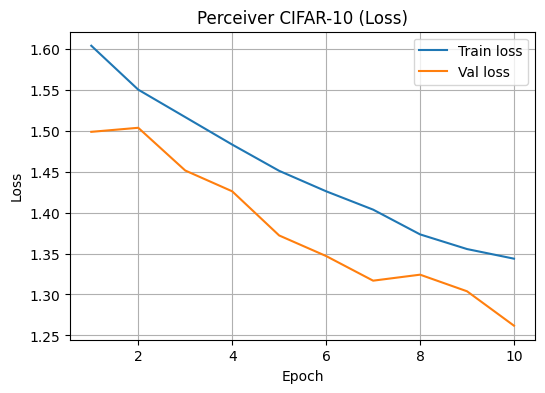

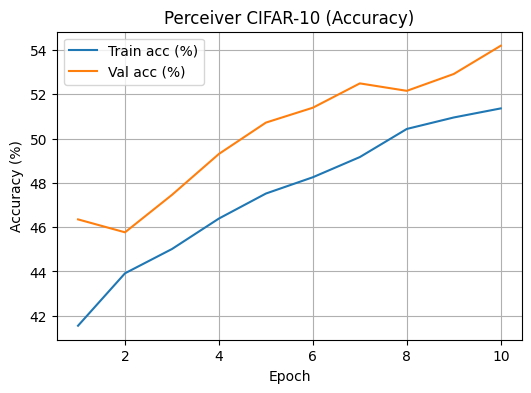

Final epoch results:
  Train loss: 1.3437 | Train acc: 51.36%
  Val   loss: 1.2618 | Val   acc: 54.19%


In [13]:
# Simple safety check: make sure history isn't empty
if len(history["train_loss"]) == 0:
    print("History is empty – train the model first.")
else:
    epochs_range = range(1, len(history["train_loss"]) + 1)

    # Loss curves
    plt.figure(figsize=(6, 4))
    plt.plot(epochs_range, history["train_loss"], label="Train loss")
    plt.plot(epochs_range, history["val_loss"], label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Perceiver CIFAR-10 (Loss)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Accuracy curves
    plt.figure(figsize=(6, 4))
    plt.plot(epochs_range, [acc * 100 for acc in history["train_acc"]], label="Train acc (%)")
    plt.plot(epochs_range, [acc * 100 for acc in history["val_acc"]], label="Val acc (%)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Perceiver CIFAR-10 (Accuracy)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print final metrics (last epoch)
    final_train_loss = history["train_loss"][-1]
    final_train_acc  = history["train_acc"][-1] * 100
    final_val_loss   = history["val_loss"][-1]
    final_val_acc    = history["val_acc"][-1] * 100

    print(f"Final epoch results:")
    print(f"  Train loss: {final_train_loss:.4f} | Train acc: {final_train_acc:.2f}%")
    print(f"  Val   loss: {final_val_loss:.4f} | Val   acc: {final_val_acc:.2f}%")

## 9. Sample Model Predictions

To verify that the model is actually learning meaningful representations beyond numerical metrics, we visualize a few CIFAR-10 test images along with the model’s predicted labels and confidence scores. This demonstrates the qualitative behavior of the reproduced Perceiver model.

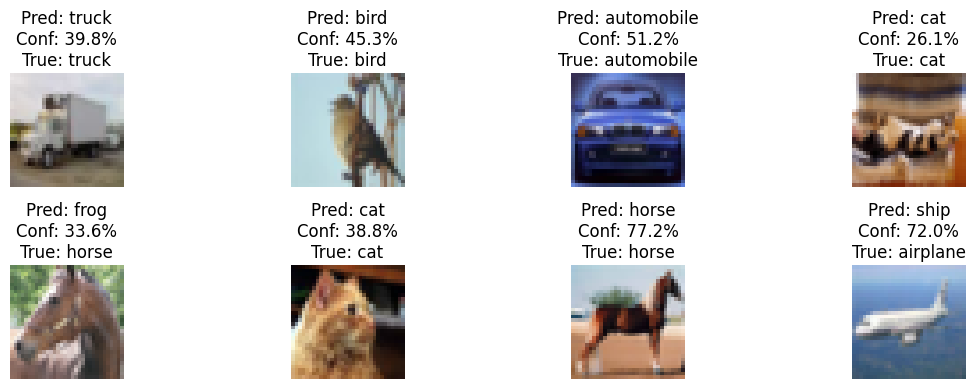

In [14]:
import random

# CIFAR-10 class names
class_names = train_ds.classes

model.eval()

# Pick a few random test samples
num_samples = 8
indices = random.sample(range(len(test_ds)), num_samples)

images = []
labels = []
for idx in indices:
    img, label = test_ds[idx]
    images.append(img)
    labels.append(label)

images_tensor = torch.stack(images).to(device)
labels_tensor = torch.tensor(labels).to(device)

with torch.no_grad():
    logits = model(images_tensor)
    probs = torch.softmax(logits, dim=-1)
    preds = probs.argmax(dim=-1)

# Plot
plt.figure(figsize=(12, 4))
for i in range(num_samples):
    plt.subplot(2, 4, i + 1)
    img = images[i].permute(1, 2, 0).cpu().numpy()
    plt.imshow(img)
    true_label = class_names[labels[i]]
    pred_label = class_names[preds[i].item()]
    confidence = probs[i][preds[i]].item() * 100
    plt.title(f"Pred: {pred_label}\nConf: {confidence:.1f}%\nTrue: {true_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## 10. Observations & Discussion

### 1. Overview of the Implemented System
This work presents a minimal, educational re-implementation of the Perceiver-style architecture applied to CIFAR-10 image classification. The implementation follows the key Perceiver principle of decoupling compute from input size by introducing a learned latent array and using cross-attention to compress high-dimensional inputs into a fixed-size latent representation. Specifically, CIFAR-10 images (32×32×3) are flattened into 1024 input tokens. Each token is augmented with a 2D Fourier positional encoding (66 dimensions with 16 frequency bands), concatenated with RGB features, and projected into the model dimension (256). A learned latent array of 128 vectors serves as the bottleneck for cross-attention, followed by a latent self-attention tower of four Transformer blocks. The final prediction is produced by mean pooling over latents and a linear classification head.

### 2.Training Setup and Observed Learning Dynamics
The model was trained for 10 epochs using AdamW (learning rate 3e-4, weight decay 1e-2) with batch size 128. Training included basic data augmentation (random crop with padding and random horizontal flip), while evaluation used unaugmented images. Across epochs, both training and validation losses decreased consistently and accuracy increased steadily, indicating stable optimization and successful end-to-end learning.

Final epoch metrics were:

-**Training loss: 1.3437, Training accuracy: 51.36%**

-**Validation loss: 1.2618, Validation accuracy: 54.19%**

The validation accuracy slightly exceeded the training accuracy, which is plausible under this setup due to the presence of augmentation and dropout during training and their absence during evaluation. Augmentation increases difficulty during training, and dropout introduces stochastic regularization; both effects can reduce training-set accuracy relative to evaluation on clean data.

### 3. Performance Interpretation
The achieved validation accuracy (~54%) demonstrates that the implementation is functionally correct and that the Perceiver bottleneck mechanism can learn meaningful representations from flattened pixels when combined with Fourier positional encodings. However, performance remains substantially below strong convolutional baselines typically reported for CIFAR-10. This gap is expected for a minimal convolution-free architecture trained from scratch on a small dataset because the model does not benefit from the strong inductive biases inherent to CNNs (e.g., locality and translation equivariance). Instead, it must learn these priors from data via attention and positional features.

Additionally, the decoder used here is intentionally lightweight (mean pooling over latents followed by a linear head). While suitable for demonstrating the architecture, this decoding approach may discard structured information present across the latent set and can limit downstream separability of classes.

### 4. Qualitative Behavior from Sample Predictions
Sample prediction visualizations show both correct classifications and typical CIFAR-10 confusions, particularly among visually similar categories (e.g., automobile vs truck, cat vs dog, airplane vs ship). Confidence values are moderate and vary widely across samples. This behavior is consistent with the quantitative accuracy level and suggests that the model has learned non-trivial features but does not yet exhibit strong class separation or calibration.

### 5. Architectural and Implementation Factors Affecting Results
Several design choices in this reproduction likely contribute to the moderate accuracy and are consistent with the goal of clarity over maximum performance:

 **Single cross-attention stage:** The input is read once through one cross-attention block. More expressive variants may use iterative cross-attention or deeper cross-attention stacks.

 **Simple latent pooling decoder:** Mean pooling is computationally efficient but may reduce representational richness compared to attention pooling or query-based decoding.

  **Fourier frequency schedule:** Frequencies are linearly spaced between 1 and max_freq. Alternative schedules (e.g., logarithmic/power-of-two spacing) may provide stronger multi-scale positional coverage.
 
 **Dataset normalization:** Images are converted to tensors but are not normalized using dataset mean/std, which commonly improves training stability and accuracy on CIFAR-10.

 **Model scale and training horizon:** With ~4M parameters and only 10 epochs of training, the model may be under-trained relative to its capacity.


## Conclusion

This project delivers a clear and functional re-implementation of a Perceiver-style architecture for CIFAR-10 classification, validating the central architectural concept of compressing large inputs through a learned latent bottleneck and processing information primarily within a fixed-size latent space. The model integrates Fourier positional encoding for spatial information without relying on convolutions, and the attention modules (cross-attention and latent self-attention) operate as intended.

Empirically, the model demonstrates stable learning over 10 epochs, improving from ~41.6% to ~51.4% training accuracy and reaching **54.19% validation accuracy** with a decreasing validation loss **(1.2618)**. These results confirm that the pipeline—tokenization, positional encoding, projection, cross-attention compression, latent refinement, and classification—forms a coherent end-to-end learner. While the achieved accuracy is lower than typical CNN baselines, this outcome aligns with expectations for a minimal, general-purpose, convolution-free architecture on a small dataset and supports the primary objective of demonstrating Perceiver’s core computational and representational principles.